In [1]:
from __future__ import division, print_function

import time
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
%matplotlib inline

In [2]:
sn_machine='/Users/mariavincenzi/PhD/SNChallenge/supernova-machine/'

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import time

import sys
import os
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
max_ml_algorithms_file=sn_machine+'max_ml_algorithms.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_ml_algorithms_file)))
import max_ml_algorithms as ml_algorithms#, max_tools as tools
max_tools_file=sn_machine+'max_tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_tools_file)))
import max_tools as tools

/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This 

In [3]:
def prepare_data4ml_algorithms(feats_file, which_feat, which_feat_err):
    f = np.array(feats_file[:, which_feat], dtype='float')
    err = np.array(feats_file[:, which_feat_err], dtype='float')
    types = np.array(feats_file[:, 1], dtype='int')

    X = f[types!=-9, :]
    Y = types[types!=-9]
    X_err = err[types!=-9, :]

    X_scaled, X_err_scaled, mean,std= tools.scale_data_with_errors(X, X_err)
    X_combined = np.concatenate((X_scaled, X_err_scaled), axis=1)

    #Combine classes into Ia (Y=1), II (Y=2), and Ib and Ic (Y=3)
    Y[(Y==21) | (Y==22) | (Y==23)]=2
    Y[(Y==32) | (Y==33)]=3
    
    return X_combined, Y, X_scaled.shape[1], mean, std



In [4]:
def run_ml_plot(X_combined, Y, Shape):
    #Preallocate results table for multiple runs
    #NOTE I'M HARD CODING THE NUMBER OF CLASSIFIERS AND PERFORMANCE
    #CRITERION HERE
    N_runs = 1
    N_classifiers = 7
    N_scores = 3
    results = -999*np.ones([N_classifiers, N_scores, N_runs])
    thresholds = -999*np.ones([N_classifiers, N_scores-1, N_runs])

    #Run classifiers and return AUC, FoM and F1 for each
    for run_counter in np.arange(N_runs):
       
        X_train_combined, X_test_combined, Y_train, Y_test = train_test_split(
        X_combined, Y, test_size=0.5, random_state=np.random.randint(100))
        
        #Seperate features and errors again
        X_train = X_train_combined[:, :Shape]
        X_train_err = X_train_combined[:, Shape:]
        X_test = X_test_combined[:, :Shape]
        X_test_err = X_test_combined[:, Shape:]
        
        #Run classifiers
        results_temp, thresholds_temp, P_RF_test, P_RF_train = tools.run_ml(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err)
        results[:, :, run_counter] = results_temp
        thresholds[:, :, run_counter] = thresholds_temp
        
        #Clean up a bit
        del results_temp, thresholds_temp, X_train_combined, X_test_combined
        
    return results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train



In [5]:
start = time.time()

feats_log10 = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')


#Features
feat_noz=[8,10,12,14]
feat_noz_err=[9,11,13,15]

feat_S2z=[6,8,10,12,14]
feat_S2z_err=[7,9,11,13,15]

feat_zph=[16,18,20,22,24]
feat_zph_err=[17,19,21,23,25]

feat_zsp=[26,28,30,32,34]
feat_zsp_err=[27,29,31,33,35]

In [6]:
def results_analysis(RES_XX):
    results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train = RES_XX
    #concatenate:
    X=np.concatenate([X_test, X_train])
    Y=np.concatenate([Y_test, Y_train])
    Xerr=np.concatenate([X_test_err, X_train_err])

    P_RF=np.concatenate([P_RF_test, P_RF_train])

    Res_Class=np.array([1+np.argmax([P_RF[i,0], P_RF[i,1], P_RF[i,2]])\
                             for i in range(len(Y))])

    FN_Ia=((Res_Class!=1))&(Y==1)
    FP_Ia=((Res_Class==1))&(Y!=1)
    TP_Ia=((Res_Class==1))&(Y==1)
    TN_Ia=((Res_Class!=1))&(Y!=1)
    
    print ('FP', len(Y[FP_Ia]), 'FN', len(Y[FN_Ia]))
    print ('TP', len(Y[TP_Ia]), 'TN', len(Y[TN_Ia]))

    print ('########  purity: ', np.round(100.*float(len(Y[TP_Ia]))/(len(Y[FP_Ia])+len(Y[TP_Ia]))))
    print ('########  efficiency: ', np.round(100*float(len(Y[TP_Ia]))/(len(Y[FN_Ia])+len(Y[TP_Ia]))))
    
    Res_Class_chop= np.ones(len(Y))*2
    Res_Class_chop[P_RF[:,0]>0.95]= 1 
    
    FN_Ia_c=((Res_Class_chop!=1))&(Y==1)
    FP_Ia_c=((Res_Class_chop==1))&(Y!=1)
    TP_Ia_c=((Res_Class_chop==1))&(Y==1)
    TN_Ia_c=((Res_Class_chop!=1))&(Y!=1)
    print ('FP', len(Y[FP_Ia_c]), 'FN', len(Y[FN_Ia_c]))
    print ('TP', len(Y[TP_Ia_c]), 'TN', len(Y[TN_Ia_c]))
    
    print ('########  purity chopping: ', np.round(100.*float(len(Y[TP_Ia_c]))/(len(Y[FP_Ia_c])+len(Y[TP_Ia_c]))))
    print ('########  efficiency chopping: ', np.round(100*float(len(Y[TP_Ia_c]))/(len(Y[FN_Ia_c])+len(Y[TP_Ia_c]))))
    
    
    return X, Xerr, Y, P_RF

scale_data_with_errors [  0.48599896  20.51908067  -4.99155179   0.53284972   0.08330253] [  0.19422685  13.36154562   0.34419364   1.55601443   0.20544196]
Upper bound on KNN N_neighbor range may be too low 

KNN optimiser time taken: 2.17919206619
('FeatImp', array([ 0.20333275,  0.0966575 ,  0.09805076,  0.29975004,  0.30220895]))
('FeatImp', array([ 0.20538862,  0.09238138,  0.09615058,  0.27274696,  0.33333245]))
('FeatImp', array([ 0.20549858,  0.09517366,  0.10102217,  0.297777  ,  0.30052859]))
('FeatImp', array([ 0.21176329,  0.0934469 ,  0.09489118,  0.26729095,  0.33260768]))
('FeatImp', array([ 0.21302429,  0.09785368,  0.10022624,  0.29025702,  0.29863877]))
('FeatImp', array([ 0.21095156,  0.09490277,  0.09407924,  0.2683493 ,  0.33171714]))
('FeatImp', array([ 0.21116588,  0.09658899,  0.09794066,  0.29278392,  0.30152054]))
('FeatImp', array([ 0.2095422 ,  0.0961367 ,  0.09587926,  0.26969742,  0.32874442]))
('FeatImp', array([ 0.21119632,  0.09717794,  0.09947615,  0.2

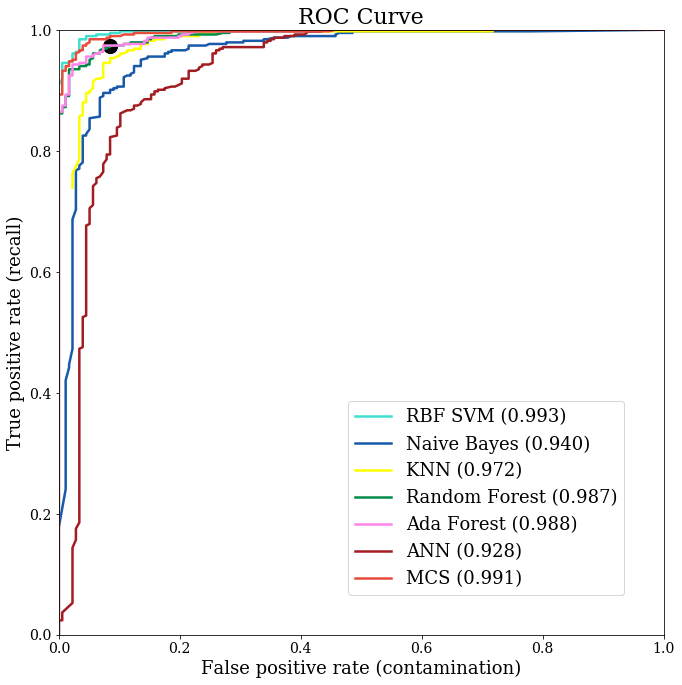

In [7]:
X_combined, Y_keys , Sh, mean_zsp, std_zsp= prepare_data4ml_algorithms(feats_log10, feat_zsp, feat_zsp_err)
RES_zsp=run_ml_plot(X_combined, Y_keys, Sh)

In [8]:
X, Xerr, Y, Prob= results_analysis(RES_zsp)

FP 29 FN 27
TP 753 TN 311
########  purity:  96.0
########  efficiency:  97.0
FP 1 FN 184
TP 596 TN 339
########  purity chopping:  100.0
########  efficiency chopping:  76.0


In [9]:
lowz=np.genfromtxt('/Users/mariavincenzi/PhD/MyBEAMS/PS1_SIM_lowzSample.FITRES', names=True, dtype=None)

def conc(x,y):
    return np.concatenate([x,y])

def err_10x(err, x0):
    return x0*np.log(10)*err

In [10]:
z = ((X[:,0]*std_zsp[0])+mean_zsp[0])
t0 =((X[:,1]*std_zsp[1])+mean_zsp[1])
x0 =10**((X[:,2]*std_zsp[2])+mean_zsp[2])
x1 =((X[:,3]*std_zsp[3])+mean_zsp[3])
c = ((X[:,4]*std_zsp[4])+mean_zsp[4])
true_type = Y

z_err = (Xerr[:,0]*std_zsp[0])
t0_err =(Xerr[:,1]*std_zsp[1])
x0_err = err_10x(Xerr[:,2]*std_zsp[2], x0)
x1_err =(Xerr[:,3]*std_zsp[3])
c_err = (Xerr[:,4]*std_zsp[4])

z_err[np.isnan(z_err)] = 10. 
t0_err[np.isnan(t0_err)] = 10. 
x0_err[np.isnan(x0_err)] = 10. 
x1_err[np.isnan(x1_err)] = 10. 
c_err[np.isnan(c_err)] = 10. 

alpha=0.11
beta=2.6
mB= 30.-19.46-2.5*np.log10(x0)+alpha*x1-beta*c
mB_err= ((2.5*np.log10(x0_err))**2+alpha*x1_err**2-beta*c_err**2)**0.5

cid_fake = np.arange(0, len(z), 1)
P_Ia = Prob[:,0]
idsurvey_fake = 15*np.ones(len(z))
field_fake = np.array(['NULL' for i in range(len(z))])
hostM_fake = -9.000*np.ones(len(z))
hostMerr_fake = -9.000*np.ones(len(z))

In [11]:
file_redshift=np.array([np.round(float(zi),10) for zi in feats_log10[:,26]])
file_x1=np.array([np.round(float(zi),3) for zi in feats_log10[:,32]])
file_colors=np.array([np.round(float(zi),4) for zi in feats_log10[:,34]])

des_file_associated=[]
mb_associated=[]
COV_x1_c=[]
COV_x1_x0=[]
COV_c_x0=[]

for i in range(len(z)):
    z_=np.round(z[i],10); x1_=np.round(x1[i],3); c_=np.round(c[i],4)
    ind = np.where(file_redshift==z_)[0]
    ind2 = np.where(file_x1==x1_)[0]
    ind3 = np.where(file_colors==c_)[0]
    index_file = np.intersect1d(np.intersect1d(ind, ind2), ind3)
    if len(index_file)!=1: 
        index_file_2= np.intersect1d(ind, ind3)
        index_file_3= np.intersect1d(ind, ind2)
        index_file_4= np.intersect1d(ind3, ind2)
        if np.any([len(index_file_2)==1, len(index_file_3)==1, len(index_file_4)==1]):
            index_file= np.array([\
                        index_file_2, index_file_3, index_file_4])[\
                             np.where([len(index_file_2)==1, len(index_file_3)==1, len(index_file_4)==1])[0]]
            des_file_associated.append((feats_log10[:,0])[index_file[0][0]])
            mb_associated.append(float((feats_log10[:,36])[index_file[0][0]]))
            COV_x1_c.append(float((feats_log10[:,37])[index_file[0][0]]))
            COV_x1_x0.append(float((feats_log10[:,38])[index_file[0][0]]))
            COV_c_x0.append(float((feats_log10[:,39])[index_file[0][0]]))
        else: 
            des_file_associated.append('')
            mb_associated.append(np.nan)
            COV_x1_c.append(10**-20)                
            COV_x1_x0.append(10**-20)                
            COV_c_x0.append(10**-20)
            print ('Nan', '%.10f'%z_, x1_, c_)
    else:
        des_file_associated.append((feats_log10[:,0])[index_file[0]])
        mb_associated.append(float((feats_log10[:,36])[index_file[0]]))
        COV_x1_c.append(float((feats_log10[:,37])[index_file[0]]))
        COV_x1_x0.append(float((feats_log10[:,38])[index_file[0]]))
        COV_c_x0.append(float((feats_log10[:,39])[index_file[0]]))

COV_x1_c=np.array(COV_x1_c)
COV_x1_x0=np.array(COV_x1_x0)
COV_c_x0=np.array(COV_c_x0)


In [12]:
for files in (feats_log10[:,0]):
    if files not in des_file_associated:
        print (files)

In [16]:
### CASE 1: Spec + Phot, no probabilities cut
### CASE 1: Spec + Phot, no probabilities cut

from astropy.io import ascii
# CID    # IDSURVEY    # TYPE    # FIELD    
# zHD    # zHDERR    # HOST_LOGMASS    # HOST_LOGMASS_ERR    
# PKMJD    ## this doesn't really care, what's important is the error on the peak day
# PKMJDERR     ## this is what matters, I use the one from SALT2
# x1    # x1ERR    # c    # cERR    
# mB    # mBERR    # x0    # x0ERR    # COV_x1_c    # COV_x1_x0    # COV_c_x0    
# PNN_Ia  #FITCHI2 FITPROB PNN_Ia PTRUE_Ia SIM_TYPE_INDEX SIM_ZCMB

conc_cid=conc(cid_fake, lowz['CID'])
sn_init=['SN:' for i in range(len(conc_cid))]

ascii.write([sn_init,\
            conc_cid,\
            conc(idsurvey_fake, lowz['IDSURVEY']),\
            conc(field_fake, lowz['FIELD']),\
            conc(z, lowz['zHD']),\
            conc(z_err, lowz['zHDERR']),\
            conc(hostM_fake , lowz['HOST_LOGMASS']),\
            conc(hostMerr_fake , lowz['HOST_LOGMASS_ERR']),\
            conc(t0 , lowz['PKMJD']),\
            conc(t0_err , lowz['PKMJDERR']),\
            conc(x1 , lowz['x1']),\
            conc(x1_err , lowz['x1ERR']),\
            conc(c , lowz['c']),\
            conc(c_err , lowz['cERR']),\
            conc(mB , lowz['mB']),\
            conc(mB_err , lowz['mBERR']),\
            conc(x0 , lowz['x0']),\
            conc(x0_err , lowz['x0ERR']),\
            conc(COV_x1_c , lowz['COV_x1_c']),\
            conc(COV_x1_x0 , lowz['COV_x1_x0']),\
            conc(COV_c_x0 , lowz['COV_c_x0']),\
            conc(P_Ia,lowz['PNN_Ia']),
            conc(P_Ia,lowz['PNN_Ia']),
            conc(true_type,lowz['TYPE']),
            conc(-99.0*np.ones(len(z)),lowz['SNRMAX1']), #useless columns
            conc(-99.0*np.ones(len(z)),lowz['SNRMAX2']), #useless columns
            conc(-99.0*np.ones(len(z)),lowz['SNRMAX3']), #useless columns
            conc(-99.0*np.ones(len(z)),lowz['NDOF']), #useless column
            conc(-99.0*np.ones(len(z)),lowz['FITCHI2']), #useless column
            conc(-99.0*np.ones(len(z)),lowz['SIM_TYPE_INDEX']), #useless column
            conc(-99.0*np.ones(len(z)),lowz['PTRUE_Ia'])], #useless column
            '/Users/mariavincenzi/PhD/MyBEAMS/Test/BEAMS/SNchallenge_data/DESSIM+lowz_sample.dat', \
            names=['VARNAMES:','CID','IDSURVEY', 'FIELD', 'zHD','zHDERR',\
                   'HOST_LOGMASS','HOST_LOGMASS_ERR','PKMJD','PKMJDERR',\
                   'x1','x1ERR', 'c', 'cERR','mB', 'mBERR','x0','x0ERR','COV_x1_c',\
                  'COV_x1_x0', 'COV_c_x0', 'PNN_Ia', 'FITPROB','TYPE', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3',\
                  'NDOF', 'FITCHI2','SIM_TYPE_INDEX','PTRUE_Ia'],
            overwrite=True)

In [17]:
### CASE 2: Spec + Phot, probabilities cut 0.95
### CASE 2: Spec + Phot, probabilities cut 0.95

from astropy.io import ascii
# CID    # IDSURVEY    # TYPE    # FIELD    
# zHD    # zHDERR    # HOST_LOGMASS    # HOST_LOGMASS_ERR    
# PKMJD    ## this doesn't really care, what's important is the error on the peak day
# PKMJDERR     ## this is what matters, I use the one from SALT2
# x1    # x1ERR    # c    # cERR    
# mB    # mBERR    # x0    # x0ERR    # COV_x1_c    # COV_x1_x0    # COV_c_x0    
# PNN_Ia 

filtra=P_Ia>0.95
P_Ia_case2 = P_Ia[filtra]
idsurvey_fake_case2 = 53*np.ones(len(z[filtra]))

conc_cid_case2=conc(cid_fake[filtra], lowz['CID'])
sn_init_case2=['SN:' for i in range(len(conc_cid_case2))]

ascii.write([sn_init_case2,\
            conc_cid_case2,\
            conc(idsurvey_fake_case2, lowz['IDSURVEY']),\
            conc(field_fake[filtra], lowz['FIELD']),\
            conc(z[filtra], lowz['zHD']),\
            conc(z_err[filtra], lowz['zHDERR']),\
            conc(hostM_fake[filtra] , lowz['HOST_LOGMASS']),\
            conc(hostMerr_fake[filtra] , lowz['HOST_LOGMASS_ERR']),\
            conc(t0[filtra] , lowz['PKMJD']),\
            conc(t0_err[filtra] , lowz['PKMJDERR']),\
            conc(x1[filtra] , lowz['x1']),\
            conc(x1_err[filtra] , lowz['x1ERR']),\
            conc(c[filtra] , lowz['c']),\
            conc(c_err[filtra] , lowz['cERR']),\
            conc(mB[filtra] , lowz['mB']),\
            conc(mB_err[filtra] , lowz['mBERR']),\
            conc(x0[filtra] , lowz['x0']),\
            conc(x0_err[filtra] , lowz['x0ERR']),\
            conc(COV_x1_c[filtra] , lowz['COV_x1_c']),\
            conc(COV_x1_x0[filtra] , lowz['COV_x1_x0']),\
            conc(COV_c_x0[filtra] , lowz['COV_c_x0']),\
            conc(np.ones(len(P_Ia_case2)), lowz['PNN_Ia']),\
            conc(np.ones(len(P_Ia_case2)), lowz['PNN_Ia']),\
            conc(np.ones(len(P_Ia_case2)), lowz['TYPE']),\
            conc(P_Ia_case2, lowz['PNN_Ia']),\
            conc(-99.0*np.ones(len(z[filtra])),lowz['SNRMAX1']), #useless columns
            conc(-99.0*np.ones(len(z[filtra])),lowz['SNRMAX2']), #useless columns
            conc(-99.0*np.ones(len(z[filtra])),lowz['SNRMAX3']), #useless columns
            conc(-99.0*np.ones(len(z[filtra])),lowz['NDOF']), #useless column
            conc(-99.0*np.ones(len(z[filtra])),lowz['FITCHI2']), #useless column
            conc(-99.0*np.ones(len(z[filtra])),lowz['SIM_TYPE_INDEX']), #useless column
            conc(-99.0*np.ones(len(z[filtra])),lowz['PTRUE_Ia']), #useless column
            ], '/Users/mariavincenzi/PhD/MyBEAMS/Test/BEAMS/SNchallenge_data/DESSIM+lowz_sample_PIaCUT.dat', \
            names=['VARNAMES:','CID','IDSURVEY', 'FIELD',\
                   'zHD','zHDERR','HOST_LOGMASS','HOST_LOGMASS_ERR','PKMJD','PKMJDERR',\
                   'x1','x1ERR', 'c', 'cERR','mB', 'mBERR','x0','x0ERR','COV_x1_c',\
                  'COV_x1_x0', 'COV_c_x0', 'PNN_Ia','FITPROB','TYPE','P_Orig_Ia', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3',\
                  'NDOF', 'FITCHI2','SIM_TYPE_INDEX','PTRUE_Ia'],
            overwrite=True)

(array([  23.,  106.,  130.,  176.,  199.,  201.,  140.,   82.,   45.,   18.]),
 array([ 0.04135 ,  0.137215,  0.23308 ,  0.328945,  0.42481 ,  0.520675,
         0.61654 ,  0.712405,  0.80827 ,  0.904135,  1.      ]),
 <a list of 10 Patch objects>)

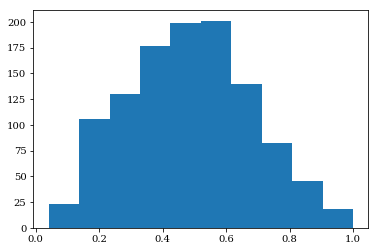

In [20]:
plt.hist(z)